In [13]:
import pandas as pd

# 1. Load your Excel file and specific sheet
file_path = r"C:\Users\Teta huguette\Downloads\online+retail+ii\online_retail_II.xlsx"
df = pd.read_excel(file_path, sheet_name='Year 2009-2010')

# 2. Clean column names
df.columns = df.columns.str.strip().str.replace(' ', '_')

# 3. Drop rows missing key fields
df.dropna(subset=['Invoice', 'InvoiceDate', 'Quantity', 'Price', 'Customer_ID'], inplace=True)

# 4. Remove canceled invoices (Invoice starting with 'C')
df = df[~df['Invoice'].astype(str).str.startswith('C')]

# 5. Remove rows with zero or negative Quantity or Price
df = df[(df['Quantity'] > 0) & (df['Price'] > 0)]

# 6. Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')

# 7. Create TotalAmount column
df['TotalAmount'] = df['Quantity'] * df['Price']

# 8. Extract time features for analysis
df['Hour'] = df['InvoiceDate'].dt.hour
df['Weekday'] = df['InvoiceDate'].dt.day_name()

# 9. Remove duplicates
df.drop_duplicates(inplace=True)

# 10. Remove empty or blank descriptions
df = df[df['Description'].notna()]
df = df[df['Description'].str.strip() != ""]

# 11. Standardize text columns
df['Description'] = df['Description'].str.strip().str.lower()
df['Country'] = df['Country'].str.strip().str.title()

# 12. Remove outliers in TotalAmount using IQR
Q1 = df['TotalAmount'].quantile(0.25)
Q3 = df['TotalAmount'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df[(df['TotalAmount'] >= lower_bound) & (df['TotalAmount'] <= upper_bound)]

# 13. Reset index
df.reset_index(drop=True, inplace=True)

# 14. Show results
print("Cleaned data shape:", df.shape)
print(df.head())


Cleaned data shape: (367073, 11)
  Invoice StockCode                     Description  Quantity  \
0  489434     21232  strawberry ceramic trinket box        24   
1  489434     22064       pink doughnut trinket pot        24   
2  489434     21871             save the planet mug        24   
3  489435     22350                        cat bowl        12   
4  489435     22195    heart measuring spoons large        24   

          InvoiceDate  Price  Customer_ID         Country  TotalAmount  Hour  \
0 2009-12-01 07:45:00   1.25      13085.0  United Kingdom         30.0     7   
1 2009-12-01 07:45:00   1.65      13085.0  United Kingdom         39.6     7   
2 2009-12-01 07:45:00   1.25      13085.0  United Kingdom         30.0     7   
3 2009-12-01 07:46:00   2.55      13085.0  United Kingdom         30.6     7   
4 2009-12-01 07:46:00   1.65      13085.0  United Kingdom         39.6     7   

   Weekday  
0  Tuesday  
1  Tuesday  
2  Tuesday  
3  Tuesday  
4  Tuesday  


=== Numerical Summary ===
            Quantity                    InvoiceDate          Price  \
count  367073.000000                         367073  367073.000000   
mean        7.540546  2010-07-01 20:31:37.802290176       2.859531   
min         1.000000            2009-12-01 07:45:00       0.001000   
25%         2.000000            2010-03-28 11:30:00       1.250000   
50%         4.000000            2010-07-11 12:45:00       1.950000   
75%        12.000000            2010-10-15 09:29:00       3.750000   
max       432.000000            2010-12-09 20:01:00      41.090000   
std         9.844081                            NaN       2.875022   

         Customer_ID    TotalAmount           Hour  
count  367073.000000  367073.000000  367073.000000  
mean    15385.974324      12.068578      12.907792  
min     12346.000000       0.001000       7.000000  
25%     14030.000000       4.250000      11.000000  
50%     15365.000000      10.200000      13.000000  
75%     16841.000000     

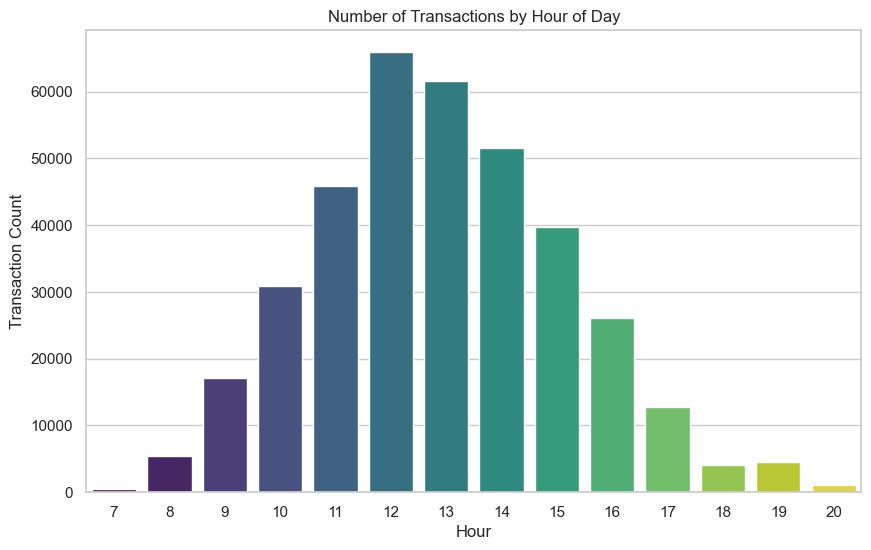

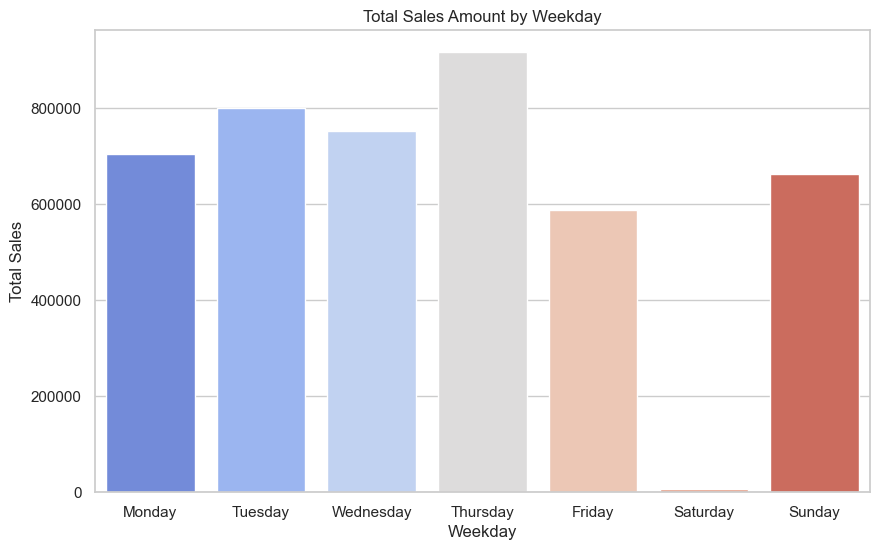

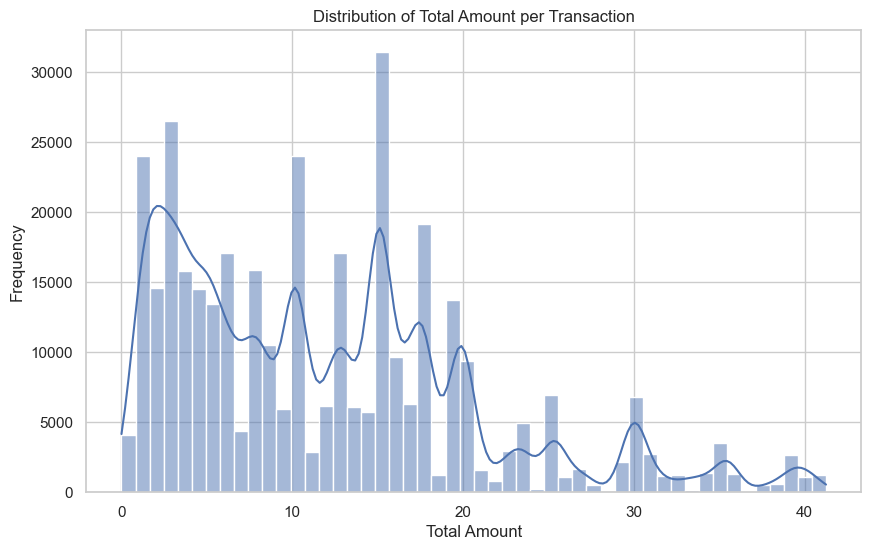


=== Top 10 Products by Quantity Sold ===
Description
world war 2 gliders asstd designs     23650
pack of 72 retro spot cake cases      21369
60 teatime fairy cake cases           18736
asstd design bubble gum ring          17550
pack of 60 pink paisley cake cases    15175
white hanging heart t-light holder    13928
assorted colour bird ornament         13175
strawberry ceramic trinket box        12228
pack of 72 skull cake cases           10127
hanging heart zinc t-light holder      9997
Name: Quantity, dtype: int64


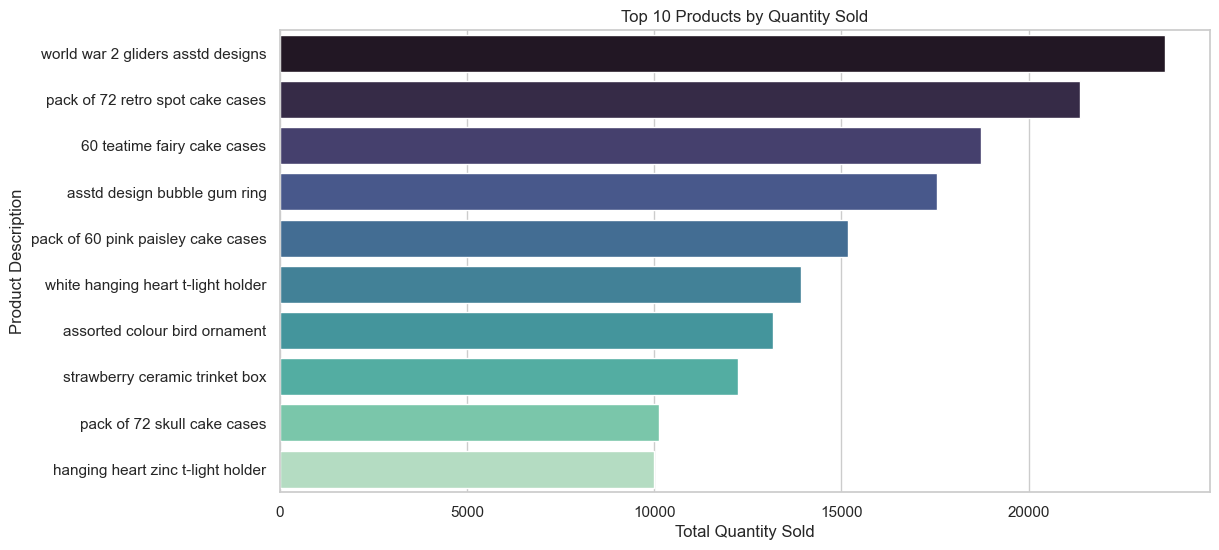

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assume df is your cleaned dataframe

# 1. Descriptive statistics
print("=== Numerical Summary ===")
print(df.describe())

# 2. Categorical unique counts
print("\n=== Unique Values in Categorical Columns ===")
print("Countries:", df['Country'].nunique())
print("Weekdays:", df['Weekday'].unique())

# 3. Top 10 Countries by number of transactions
top_countries = df['Country'].value_counts().head(10)
print("\n=== Top 10 Countries by Transactions ===")
print(top_countries)

# 4. Total Amount spent per country (top 10)
total_per_country = df.groupby('Country')['TotalAmount'].sum().sort_values(ascending=False).head(10)
print("\n=== Top 10 Countries by Total Sales ===")
print(total_per_country)

# 5. Plot: Transactions count by Hour — fixed hue=x and legend=False
plt.figure(figsize=(10,6))
sns.countplot(
    x='Hour', data=df, 
    palette='viridis', 
    order=sorted(df['Hour'].unique()), 
    hue='Hour',   # Fix here
    legend=False
)
plt.title('Number of Transactions by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Transaction Count')
plt.show()

# 6. Plot: Total sales by Weekday — fixed hue=x and legend=False
plt.figure(figsize=(10,6))
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sales_by_weekday = df.groupby('Weekday')['TotalAmount'].sum().reindex(weekday_order)
sns.barplot(
    x=sales_by_weekday.index, y=sales_by_weekday.values, 
    palette='coolwarm', 
    hue=sales_by_weekday.index,  # Fix here
    legend=False
)
plt.title('Total Sales Amount by Weekday')
plt.xlabel('Weekday')
plt.ylabel('Total Sales')
plt.show()

# 7. Plot: Distribution of TotalAmount per transaction (no palette issue)
plt.figure(figsize=(10,6))
sns.histplot(df['TotalAmount'], bins=50, kde=True)
plt.title('Distribution of Total Amount per Transaction')
plt.xlabel('Total Amount')
plt.ylabel('Frequency')
plt.show()

# 8. Top 10 Products by total quantity sold
top_products = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)
print("\n=== Top 10 Products by Quantity Sold ===")
print(top_products)

# 9. Plot: Top products by quantity sold — fixed hue=y and legend=False
plt.figure(figsize=(12,6))
sns.barplot(
    x=top_products.values, y=top_products.index, 
    palette='mako', 
    hue=top_products.index,   # Fix here
    legend=False
)
plt.title('Top 10 Products by Quantity Sold')
plt.xlabel('Total Quantity Sold')
plt.ylabel('Product Description')
plt.show()


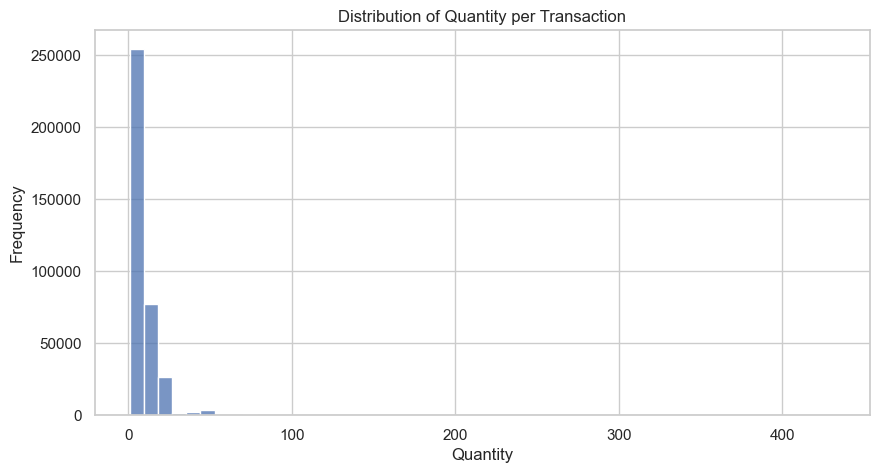

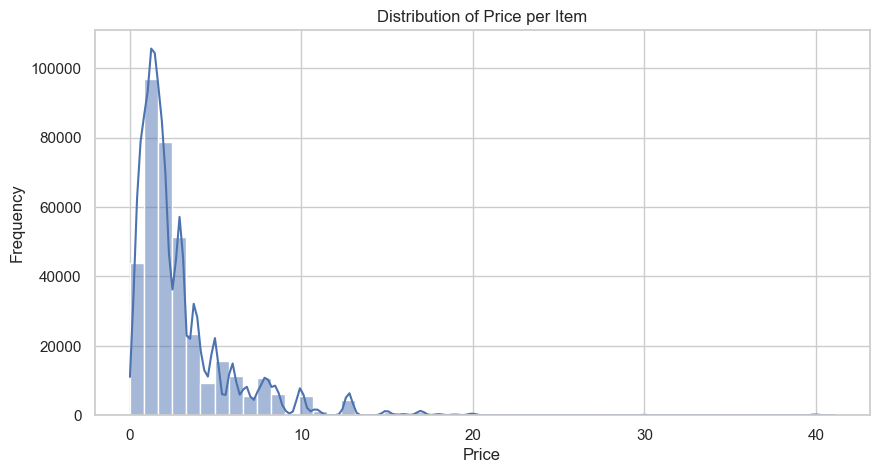

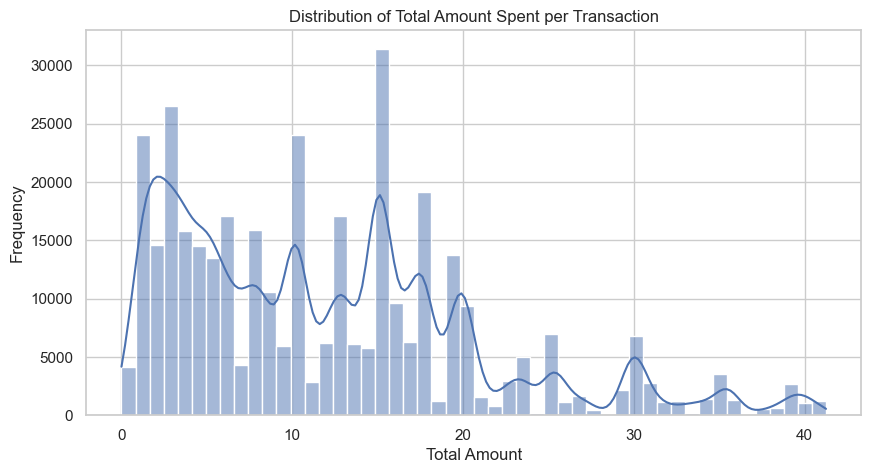

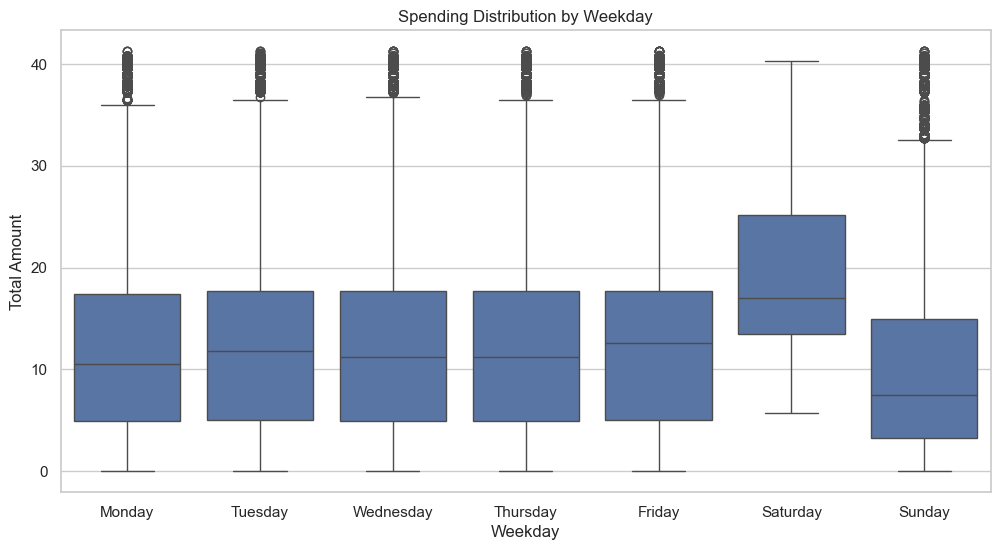

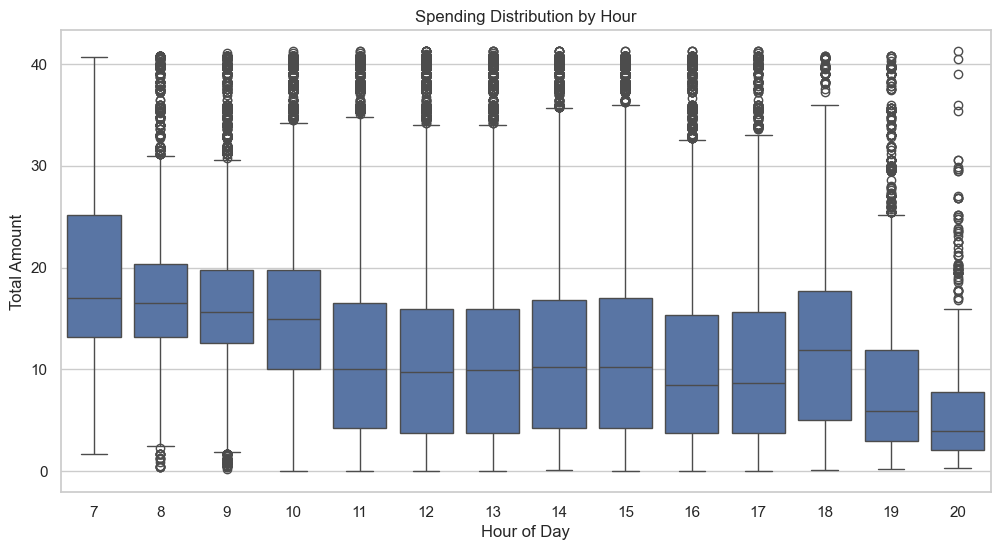

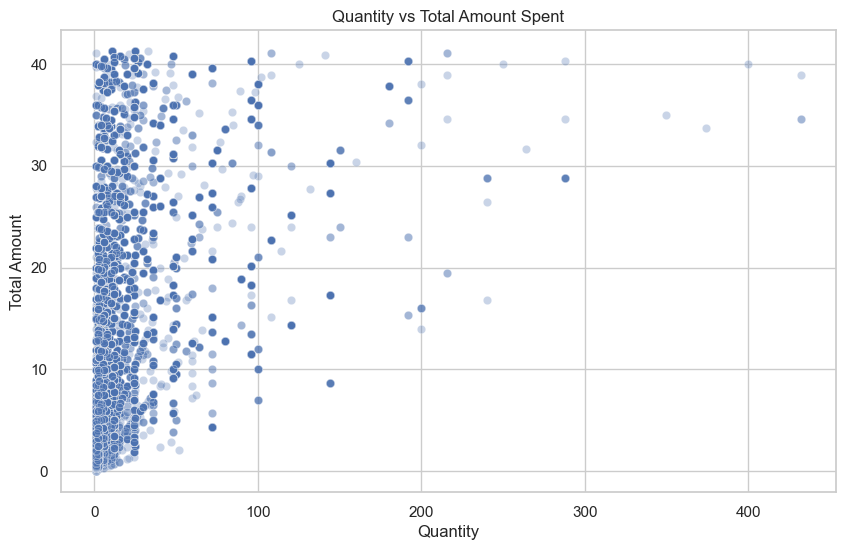

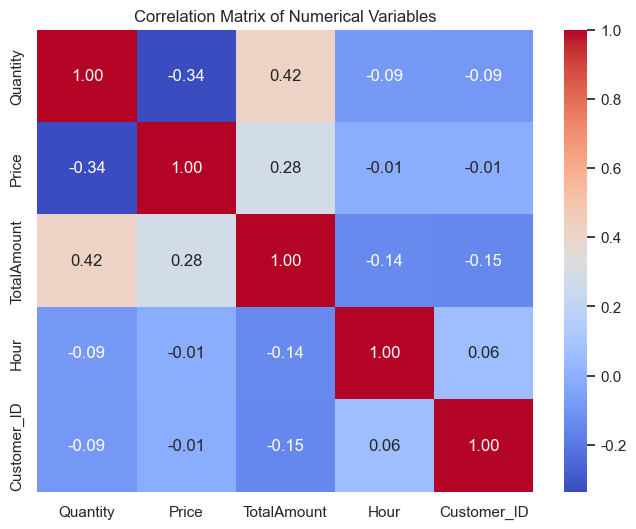

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a nice style for plots
sns.set_style('whitegrid')

# 1. Distribution of Quantity per transaction
plt.figure(figsize=(10, 5))
sns.histplot(df['Quantity'], bins=50, kde=False)
plt.title('Distribution of Quantity per Transaction')
plt.xlabel('Quantity')
plt.ylabel('Frequency')
plt.show()

# 2. Distribution of Price per item
plt.figure(figsize=(10, 5))
sns.histplot(df['Price'], bins=50, kde=True)
plt.title('Distribution of Price per Item')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

# 3. Distribution of TotalAmount (Amount spent per transaction)
plt.figure(figsize=(10, 5))
sns.histplot(df['TotalAmount'], bins=50, kde=True)
plt.title('Distribution of Total Amount Spent per Transaction')
plt.xlabel('Total Amount')
plt.ylabel('Frequency')
plt.show()

# 4. Boxplot of TotalAmount by Weekday (to see spending patterns by day)
plt.figure(figsize=(12, 6))
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.boxplot(x='Weekday', y='TotalAmount', data=df, order=order)
plt.title('Spending Distribution by Weekday')
plt.xlabel('Weekday')
plt.ylabel('Total Amount')
plt.show()

# 5. Boxplot of TotalAmount by Hour (to see spending patterns by time of day)
plt.figure(figsize=(12, 6))
sns.boxplot(x='Hour', y='TotalAmount', data=df)
plt.title('Spending Distribution by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Total Amount')
plt.show()

# 6. Scatter plot: Quantity vs TotalAmount (are higher quantities leading to higher spending?)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Quantity', y='TotalAmount', data=df, alpha=0.3)
plt.title('Quantity vs Total Amount Spent')
plt.xlabel('Quantity')
plt.ylabel('Total Amount')
plt.show()

# 7. Correlation heatmap of numerical variables
plt.figure(figsize=(8,6))
numeric_cols = ['Quantity', 'Price', 'TotalAmount', 'Hour', 'Customer_ID']
corr = df[numeric_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Variables')
plt.show()


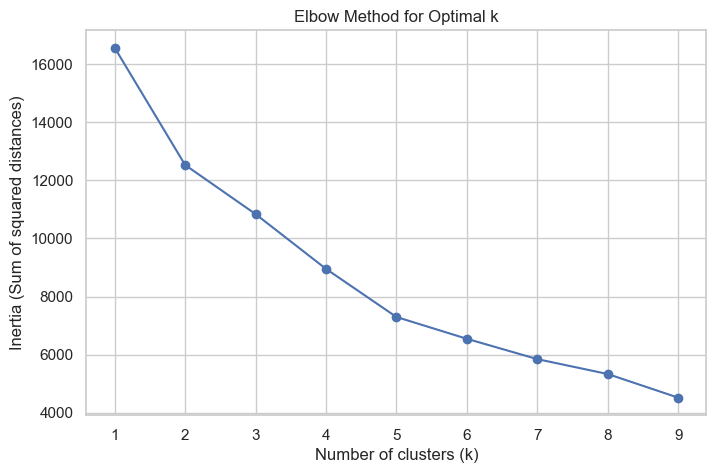

         TotalAmount   Quantity  PurchaseFrequency       Hour
Cluster                                                      
0          18.242164  12.920563          57.357097  11.058152
1          17.775100  10.981098          51.306186  14.123124
2           7.250973   4.169919         161.281605  13.344627


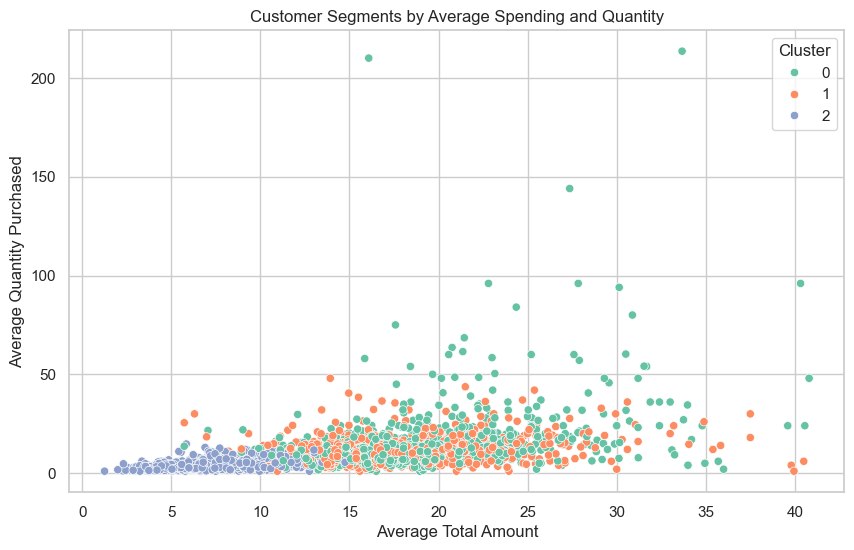

In [19]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Aggregate customer-level data
customer_data = df.groupby('Customer_ID').agg({
    'TotalAmount': 'mean',
    'Quantity': 'mean',
    'Invoice': 'count',  # purchase frequency
    'Hour': 'mean'
}).rename(columns={'Invoice': 'PurchaseFrequency'}).reset_index()

# Features for clustering
features = ['TotalAmount', 'Quantity', 'PurchaseFrequency', 'Hour']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(customer_data[features])

# Choose number of clusters (Elbow method)
inertia = []
K_range = range(1, 10)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot Elbow curve
plt.figure(figsize=(8,5))
plt.plot(K_range, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (Sum of squared distances)')
plt.title('Elbow Method for Optimal k')
plt.show()

# Choose k (e.g., 3) based on elbow plot
k_optimal = 3
kmeans = KMeans(n_clusters=k_optimal, random_state=42)
customer_data['Cluster'] = kmeans.fit_predict(X_scaled)

# Analyze clusters
print(customer_data.groupby('Cluster')[features].mean())

# Visualize clusters in 2D (using first two features)
plt.figure(figsize=(10,6))
sns.scatterplot(
    x=customer_data['TotalAmount'], 
    y=customer_data['Quantity'], 
    hue=customer_data['Cluster'],
    palette='Set2'
)
plt.title('Customer Segments by Average Spending and Quantity')
plt.xlabel('Average Total Amount')
plt.ylabel('Average Quantity Purchased')
plt.show()



Cluster centers (average customer profile):
   TotalAmount    Quantity  PurchaseFrequency
0    18.196751   11.973239          54.523844
1     7.448895    4.320464         156.209921
2    25.703333  189.166667           2.666667

Cluster 0:
Number of customers: 2746
Avg spending: 18.20
Avg quantity: 11.97
Avg purchase frequency: 54.49

Cluster 1:
Number of customers: 1392
Avg spending: 7.45
Avg quantity: 4.32
Avg purchase frequency: 156.21

Cluster 2:
Number of customers: 3
Avg spending: 25.70
Avg quantity: 189.17
Avg purchase frequency: 2.67


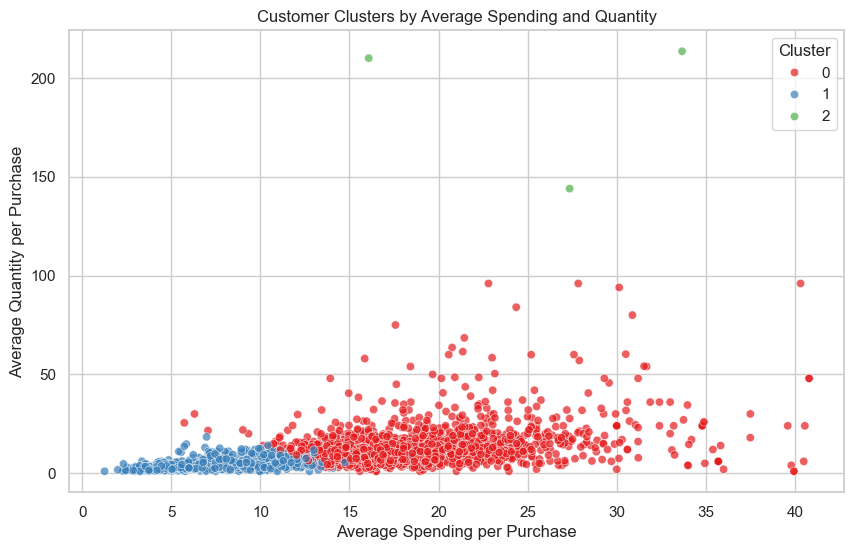

In [22]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is your cleaned dataframe with these columns:
# ['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'Price', 'Customer_ID', 'Country']

# Calculate total amount per row
df['TotalAmount'] = df['Quantity'] * df['Price']

# Drop rows with missing Customer_ID (if any remain)
df = df.dropna(subset=['Customer_ID'])
df['Customer_ID'] = df['Customer_ID'].astype(int)

# Aggregate data by customer
customer_df = df.groupby('Customer_ID').agg({
    'TotalAmount': 'mean',        # average spending per purchase
    'Quantity': 'mean',           # average quantity per purchase
    'Invoice': 'count'            # number of purchases (frequency)
}).rename(columns={'Invoice': 'PurchaseFrequency'}).reset_index()

# Prepare features for clustering
features = ['TotalAmount', 'Quantity', 'PurchaseFrequency']
X = customer_df[features]

# Scale features for clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Choose number of clusters
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
customer_df['Cluster'] = kmeans.fit_predict(X_scaled)

# Print cluster centers (inverse scale)
centers = scaler.inverse_transform(kmeans.cluster_centers_)
centers_df = pd.DataFrame(centers, columns=features)
print("Cluster centers (average customer profile):")
print(centers_df)

# Analyze clusters
for c in range(k):
    cluster_data = customer_df[customer_df['Cluster'] == c]
    print(f"\nCluster {c}:")
    print(f"Number of customers: {cluster_data.shape[0]}")
    print(f"Avg spending: {cluster_data['TotalAmount'].mean():.2f}")
    print(f"Avg quantity: {cluster_data['Quantity'].mean():.2f}")
    print(f"Avg purchase frequency: {cluster_data['PurchaseFrequency'].mean():.2f}")

# Visualize clusters by spending and quantity
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=customer_df,
    x='TotalAmount',
    y='Quantity',
    hue='Cluster',
    palette='Set1',
    alpha=0.7
)
plt.title('Customer Clusters by Average Spending and Quantity')
plt.xlabel('Average Spending per Purchase')
plt.ylabel('Average Quantity per Purchase')
plt.show()


Silhouette Score: 0.467

Cluster Centers (Original Scale):
   TotalAmount    Quantity  PurchaseFrequency
0    18.196751   11.973239          54.523844
1     7.448895    4.320464         156.209921
2    25.703333  189.166667           2.666667

Number of customers in each cluster:
Cluster
0    2746
1    1392
2       3
Name: count, dtype: int64


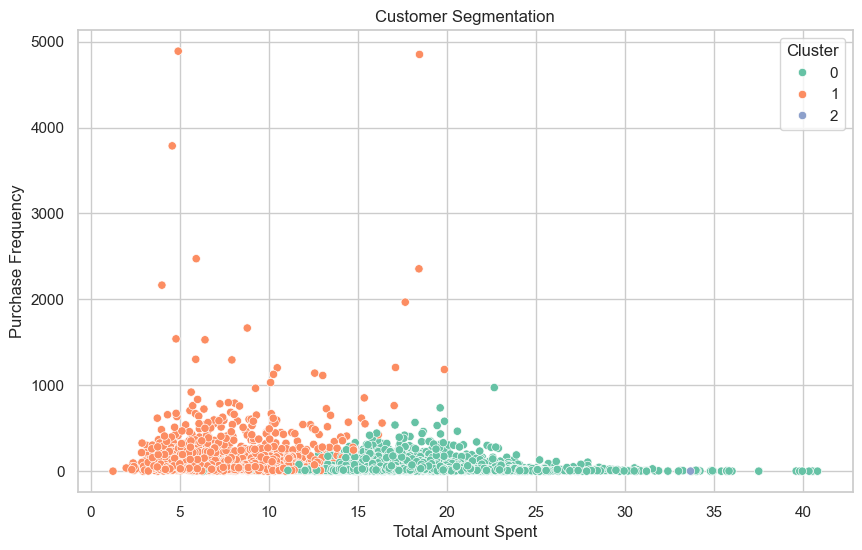

In [25]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming customer_df already exists with necessary columns
# and includes: TotalAmount, Quantity, PurchaseFrequency

# Step 1: Feature selection
features = customer_df[['TotalAmount', 'Quantity', 'PurchaseFrequency']]

# Step 2: Scaling
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Step 3: Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(features_scaled)

# Assign cluster labels
customer_df['Cluster'] = kmeans.labels_

# Step 4: Evaluation
score = silhouette_score(features_scaled, kmeans.labels_)
print(f"Silhouette Score: {score:.3f}")

# Step 5: Cluster centers in original scale
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
cluster_df = pd.DataFrame(cluster_centers, columns=['TotalAmount', 'Quantity', 'PurchaseFrequency'])
print("\nCluster Centers (Original Scale):")
print(cluster_df)

# Step 6: Customers per cluster
cluster_counts = customer_df['Cluster'].value_counts().sort_index()
print("\nNumber of customers in each cluster:")
print(cluster_counts)

# Step 7: Visualization
plt.figure(figsize=(10, 6))
sns.scatterplot(data=customer_df, x='TotalAmount', y='PurchaseFrequency', hue='Cluster', palette='Set2')
plt.title("Customer Segmentation")
plt.xlabel("Total Amount Spent")
plt.ylabel("Purchase Frequency")
plt.grid(True)
plt.show()


Data loaded. Shape: (525461, 8)
Silhouette Score: 0.915

Cluster Centers (Average Customer Profile):
          Customer ID    TotalAmount       Quantity  PurchaseFrequency
Cluster                                                               
0        15350.349330    1431.469466     822.594448           3.795578
1        14901.833333  185302.268333  136469.333333          95.500000
2        15316.254545   29727.508418   22230.709091          45.545455

Cluster 0:
 - Number of customers: 4251
 - Avg spending: 1431.47
 - Avg quantity: 822.59
 - Avg purchase frequency: 3.80

Cluster 1:
 - Number of customers: 6
 - Avg spending: 185302.27
 - Avg quantity: 136469.33
 - Avg purchase frequency: 95.50

Cluster 2:
 - Number of customers: 55
 - Avg spending: 29727.51
 - Avg quantity: 22230.71
 - Avg purchase frequency: 45.55


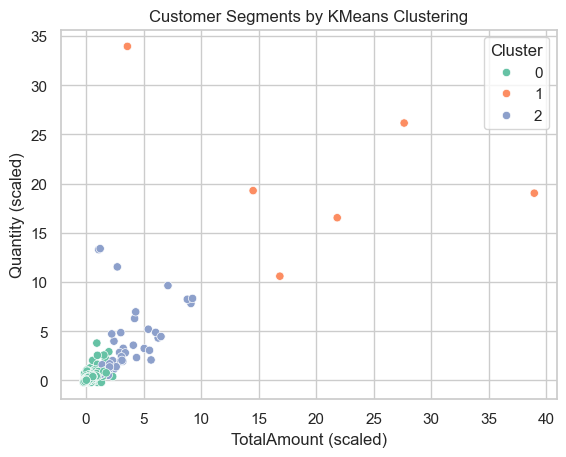

In [26]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# ----------------------
# Step 1: Load and Clean Data
# ----------------------

def load_data(file_path):
    """Load Excel file into DataFrame."""
    df = pd.read_excel(file_path)
    print("Data loaded. Shape:", df.shape)
    return df

def preprocess_data(df):
    """Clean and prepare the data for clustering."""
    # Drop rows with missing values in essential columns
    df = df.dropna(subset=['Invoice', 'Quantity', 'Price'])
    
    # Remove negative or zero values
    df = df[(df['Quantity'] > 0) & (df['Price'] > 0)]

    # Add 'TotalAmount' column
    df['TotalAmount'] = df['Quantity'] * df['Price']

    # Group by CustomerID to get behavior
    customer_df = df.groupby('Customer ID').agg({
        'TotalAmount': 'sum',
        'Quantity': 'sum',
        'Invoice': 'nunique'
    }).reset_index()

    customer_df.rename(columns={'Invoice': 'PurchaseFrequency'}, inplace=True)
    
    return customer_df

# ----------------------
# Step 2: Scale Features
# ----------------------

def scale_features(df):
    """Scale numeric features for clustering."""
    scaler = StandardScaler()
    features = df[['TotalAmount', 'Quantity', 'PurchaseFrequency']]
    scaled = scaler.fit_transform(features)
    return scaled

# ----------------------
# Step 3: Train Clustering Model
# ----------------------

def train_kmeans(data, n_clusters=3):
    """Train KMeans clustering model."""
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
    kmeans.fit(data)
    return kmeans

# ----------------------
# Step 4: Evaluate Model
# ----------------------

def evaluate_model(data, labels):
    """Evaluate clustering using Silhouette Score."""
    score = silhouette_score(data, labels)
    print(f"Silhouette Score: {score:.3f}")
    return score

# ----------------------
# Step 5: Profile Clusters
# ----------------------

def profile_clusters(original_df, labels):
    """Add cluster labels and show profiles."""
    original_df['Cluster'] = labels
    centers = original_df.groupby('Cluster').mean(numeric_only=True)

    print("\nCluster Centers (Average Customer Profile):")
    print(centers)

    for c in sorted(original_df['Cluster'].unique()):
        cluster_data = original_df[original_df['Cluster'] == c]
        print(f"\nCluster {c}:")
        print(f" - Number of customers: {len(cluster_data)}")
        print(f" - Avg spending: {cluster_data['TotalAmount'].mean():.2f}")
        print(f" - Avg quantity: {cluster_data['Quantity'].mean():.2f}")
        print(f" - Avg purchase frequency: {cluster_data['PurchaseFrequency'].mean():.2f}")

    return original_df

# ----------------------
# Step 6: Main Pipeline
# ----------------------

def main():
    file_path = r"C:\Users\Teta huguette\Downloads\online+retail+ii\online_retail_II.xlsx"

    # Load and process data
    raw_df = load_data(file_path)
    customer_df = preprocess_data(raw_df)

    # Scale features
    features_scaled = scale_features(customer_df)

    # Train model
    kmeans = train_kmeans(features_scaled, n_clusters=3)

    # Evaluate
    evaluate_model(features_scaled, kmeans.labels_)

    # Profile
    clustered_df = profile_clusters(customer_df.copy(), kmeans.labels_)

    # Optional: Visualize clusters
    sns.scatterplot(
        x=features_scaled[:, 0], y=features_scaled[:, 1], hue=kmeans.labels_, palette='Set2'
    )
    plt.title("Customer Segments by KMeans Clustering")
    plt.xlabel("TotalAmount (scaled)")
    plt.ylabel("Quantity (scaled)")
    plt.legend(title="Cluster")
    plt.show()

if __name__ == "__main__":
    main()


🔄 Loading data...
 Preprocessing...
 Engineering features...
 Scaling features...
 Clustering...
 Evaluating...

Silhouette Score: 0.812
 Visualizing...


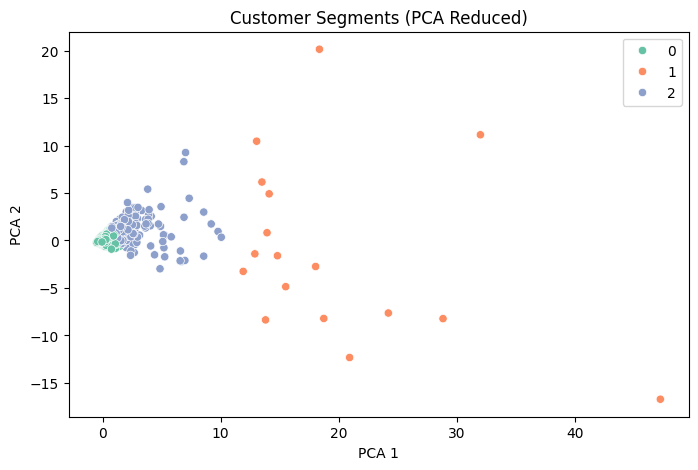

Summarizing...

Cluster Summary (Average Customer Profiles):
   Cluster    TotalAmount      Quantity  PurchaseFrequency  CustomerCount
0        0    1091.631447    649.209626           3.072319           4093
1        1  112694.244706  64501.000000          70.352941             17
2        2   11085.860658   6202.109649          20.881579            228


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# Load Data
def load_data(file_path):
    df = pd.read_excel(file_path, sheet_name='Year 2010-2011')
    return df

# Preprocess Data
def preprocess_data(df):
    df = df.dropna()
    df = df[df['Quantity'] > 0]
    df = df[df['Price'] > 0]
    df['TotalAmount'] = df['Quantity'] * df['Price']
    return df

# Feature Engineering
def engineer_features(df):
    customer_df = df.groupby('Customer ID').agg({
        'TotalAmount': 'sum',
        'Quantity': 'sum',
        'Invoice': 'nunique'
    }).rename(columns={'Invoice': 'PurchaseFrequency'}).reset_index()
    return customer_df

# Scale Features
def scale_features(df):
    features = df[['TotalAmount', 'Quantity', 'PurchaseFrequency']]
    scaler = StandardScaler()
    scaled = scaler.fit_transform(features)
    return scaled

# Apply KMeans
def apply_kmeans(features_scaled, n_clusters=3):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(features_scaled)
    return kmeans, clusters

# Evaluate Clustering
def evaluate_model(features_scaled, clusters):
    score = silhouette_score(features_scaled, clusters)
    print(f"\nSilhouette Score: {score:.3f}")
    return score

# Visualize Clusters using PCA
def plot_clusters_pca(features_scaled, clusters):
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(features_scaled)
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=reduced[:, 0], y=reduced[:, 1], hue=clusters, palette='Set2')
    plt.title("Customer Segments (PCA Reduced)")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.show()

# Summary of Cluster Profiles
def summarize_clusters(customer_df, clusters):
    customer_df['Cluster'] = clusters
    cluster_summary = customer_df.groupby('Cluster').agg({
        'TotalAmount': 'mean',
        'Quantity': 'mean',
        'PurchaseFrequency': 'mean',
        'Customer ID': 'count'
    }).rename(columns={'Customer ID': 'CustomerCount'}).reset_index()
    print("\nCluster Summary (Average Customer Profiles):")
    print(cluster_summary)
    return cluster_summary

# Main Function
def main():
    file_path = r"C:\Users\Teta huguette\Downloads\online+retail+ii\online_retail_II.xlsx"
    
    print("🔄 Loading data...")
    df = load_data(file_path)

    print(" Preprocessing...")
    df = preprocess_data(df)

    print(" Engineering features...")
    customer_df = engineer_features(df)

    print(" Scaling features...")
    features_scaled = scale_features(customer_df)

    print(" Clustering...")
    kmeans, clusters = apply_kmeans(features_scaled, n_clusters=3)

    print(" Evaluating...")
    evaluate_model(features_scaled, clusters)

    print(" Visualizing...")
    plot_clusters_pca(features_scaled, clusters)

    print("Summarizing...")
    summarize_clusters(customer_df, clusters)

if __name__ == "__main__":
    main()


In [3]:
#  Imports
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

#  Load the dataset
file_path = r"C:\Users\Teta huguette\Downloads\online+retail+ii\online_retail_II.xlsx"
df = pd.read_excel(file_path, sheet_name='Year 2010-2011')

#  Clean the data
def clean_data(df):
    df = df.dropna(subset=['Customer ID'])
    df = df[df['Quantity'] > 0]
    df = df[df['Price'] > 0]
    df['TotalAmount'] = df['Quantity'] * df['Price']
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
    return df

df = clean_data(df)

#  Feature Engineering (per customer)
def engineer_features(df):
    customer_group = df.groupby('Customer ID').agg({
        'Invoice': pd.Series.nunique,
        'Quantity': 'sum',
        'TotalAmount': 'sum'
    }).rename(columns={
        'Invoice': 'PurchaseFrequency',
        'Quantity': 'TotalQuantity',
        'TotalAmount': 'TotalSpending'
    })
    return customer_group

features_df = engineer_features(df)

#  Scaling
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_df)

#  Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
features_df['Cluster'] = kmeans.fit_predict(features_scaled)

#  Silhouette Score
score = silhouette_score(features_scaled, kmeans.labels_)
print(f"Silhouette Score: {score:.3f}")

# Combine with Customer ID
features_df.reset_index(inplace=True)

# Define final_df for Power BI
final_df = features_df.copy()

#  Save to CSV
final_df.to_csv("cleaned_customer_data.csv", index=False)
print(" Data exported to cleaned_customer_data.csv")


Silhouette Score: 0.812
✅ Data exported to cleaned_customer_data.csv


In [9]:
final_df.head()

,Customer ID,PurchaseFrequency,TotalQuantity,TotalSpending,Cluster
0,12346.0,1,74215,77183.60,1
1,12347.0,7,2458,4310.00,0
2,12348.0,4,2341,1797.24,0
3,12349.0,1,631,1757.55,0
4,12350.0,1,197,334.40,0
